In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy as sp
import seaborn as sns
from scipy import stats
import bayes_toolbox.glm as bg

sns.set_theme("talk")
sns.set_style("darkgrid")

%matplotlib inline
%config Inline.figure_format = 'retina'

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv("../results/ige_ege_nospe.csv")
df["adaptation"] = np.nan
df["total error"] = np.nan
df.columns

Index(['si', 'SN', 'id', 'tester', 'TN', 'move_cycle', 'hX', 'hY', 'rot_hX',
       'rot_hY', 'rotation', 'tgt_jump', 'hand_max_dist', 'radvelmax', 'tgtX',
       'tgtY', 'rot_hand_theta', 'theta_maxradv', 'raw_ep_hand_ang', 'tgt_ang',
       'tgt_dist', 'fbi', 'MT', 'RT', 'ST', 'adaptation', 'total error'],
      dtype='object')

In [3]:
df.head()

,si,SN,id,tester,TN,move_cycle,hX,hY,rot_hX,rot_hY,...,theta_maxradv,raw_ep_hand_ang,tgt_ang,tgt_dist,fbi,MT,RT,ST,adaptation,total error
0,1,1,01_i,s,1,1,0.816301,100.458669,0.0,0.0,...,4.176605,90.465560,90,90,1,0.767161,1.392412,4.819952,NaN,NaN
1,1,1,01_i,s,2,2,0.456301,88.578669,0.0,0.0,...,-0.607982,90.295149,90,90,1,0.500046,0.510776,1.837063,NaN,NaN
2,1,1,01_i,s,3,3,-0.203699,98.778669,0.0,0.0,...,-0.703997,89.881846,90,90,1,0.527277,0.362191,1.662021,NaN,NaN
3,1,1,01_i,s,4,4,-0.403699,97.538669,0.0,0.0,...,3.065018,89.762862,90,90,1,0.504024,0.395423,1.800106,NaN,NaN
4,1,1,01_i,s,5,5,0.736301,61.098669,0.0,0.0,...,3.581982,90.690439,90,90,1,0.170532,0.316748,1.388063,NaN,NaN


In [4]:
# Outlier removal
z_thresh = 4

# z-score hand angle data
df["theta_maxradv_z"] = df.groupby("SN")["theta_maxradv"].transform(stats.zscore)

# Create outlier column
df["theta_maxradv_outlier"] = np.abs(df["theta_maxradv_z"]) > z_thresh

# Calculate within-subject mean using non-outlier trials only
df["theta_maxradv_mean"] = df[np.abs(df["theta_maxradv_z"]) <= z_thresh].groupby("SN")["theta_maxradv"].transform(np.mean)

# Replace outliers with within-subject mean values
df["theta_maxradv_mean"] = df.groupby("SN")["theta_maxradv_mean"].transform(lambda x: x.fillna(np.nanmean(x)))

# Create final column with "cleaned" hand angles
df["theta_maxradv_clean"] = np.where(np.abs(df["theta_maxradv_z"]) > z_thresh,
                                     df["theta_maxradv_mean"],
                                     df["theta_maxradv"])

# df[np.abs(df["theta_maxradv_z"]) > z_thresh].sample(10)

### Writing custom-function for outlier removal

In [5]:
# def replace_outliers(z_thresh, var, subj_id):
    
#     # z-score var
#     df["var" + "_z"] = df.groupby(subj_id)[var].transform(stats.zscore)
    
#     # Create outlier column
#     df["var" + "_outlier"] = np.abs(df["var_z"]) > z_thresh

#     # Calculate within-subject mean using non-outlier trials only
#     df["var" + "_mean"] = df[np.abs(df["var_z"]) <= z_thresh].groupby("subj_id")["var"].transform(np.mean)

#     # Replace outliers with within-subject mean values
#     df["var_mean"] = df.groupby("subj_id")["var_mean"].transform(lambda x: x.fillna(np.nanmean(x)))

#     # Create final column with "cleaned" hand angles
#     df["var" + "_clean"] = np.where(np.abs(df["var_z"]) > z_thresh,
#                                      df["var_mean"],
#                                      df["var"])
    
#     return df["var_z"]

In [6]:
# View sample of rows to confirm hand angle varies by subject
df[df["theta_maxradv_z"] > z_thresh].sample()

# Count number of outliers per participant
df.groupby("SN")["theta_maxradv_outlier"].sum()

# Check by again printing a sample of outlier rows
df[df["theta_maxradv_z"] > z_thresh].sample()

,si,SN,id,tester,TN,move_cycle,hX,hY,rot_hX,rot_hY,...,fbi,MT,RT,ST,adaptation,total error,theta_maxradv_z,theta_maxradv_outlier,theta_maxradv_mean,theta_maxradv_clean
3802,3,3,03_i,s,63,63,0.616301,91.438669,0.0,0.0,...,1,1.410601,0.908285,1.474119,NaN,NaN,37.865302,True,0.264179,0.264179


In [7]:
# # Find outliers and remove based on hard threshold
# outlier_idx = np.where(np.abs(df.theta_maxradv) >= 45)
# outlier_idx = np.asarray(outlier_idx).flatten()
# print(f'Total number of outliers: ', len(outlier_idx))
# cols = ["rotation", "rot_hand_theta", "theta_maxradv", "raw_ep_hand_ang", "MT", "RT"]
# df.loc[outlier_idx, cols] = np.nan


In [8]:
# # For regressing adaptation over total error at each level of ege:
# # 1) Split data into groups defined by ege;
# # 2) Bin data for each perturbation level into quintiles
# df_adapt["bin_vis"] = df_adapt.groupby("ege")["total_err_vis"].transform(lambda x: pd.qcut(x, 5, labels=[1, 2, 3, 4, 5]))
# df_adapt["bin_ege"] = df_adapt.groupby("ege")["total_err_ege"].transform(lambda x: pd.qcut(x, 5, labels=[1, 2, 3, 4, 5]))

# # Create data frames of binned data
# df_bin_vis = df_adapt.groupby(["ege", "bin_vis"])[["total_err_vis", "adapt_vis"]].mean()
# df_bin_vis.reset_index(inplace=True) # flatten data frame for easier indexing

# df_bin_ege = df_adapt.groupby(["ege", "bin_ege"])[["total_err_ege", "adapt_ege"]].mean()
# df_bin_ege.reset_index(inplace=True)

/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Adaptation to ege-vmr has slope of -0.5041404720543364, p-val of 6.353331890780732e-19.
Adaptation to ige on rotation trials has slope of 0.03238355089093304, p-val of 0.6303283765845387.
Adaptation to ege-target jump has slope of -0.30751694409782215, p-val of 1.5161858297005455e-07.
Adaptation to ige on target jump has slope of -0.00145965852310538, p-val of 0.9508458580525966.


/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Adaptation to ege-vmr has slope of -0.7077894833390277, p-val of 1.565696306242204e-44.
Adaptation to ige on rotation trials has slope of -0.08135709317849162, p-val of 0.286247917336423.
Adaptation to ege-target jump has slope of -0.3648541966117924, p-val of 1.918678549923242e-13.
Adaptation to ige on target jump has slope of 0.04355734571649547, p-val of 0.521356894108383.


/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Adaptation to ege-vmr has slope of -0.4654089282743836, p-val of 3.433266462088066e-24.
Adaptation to ige on rotation trials has slope of -0.20425589676339634, p-val of 0.0017055009584743144.
Adaptation to ege-target jump has slope of -0.4539967578091417, p-val of 3.577996950660686e-22.
Adaptation to ige on target jump has slope of -0.10431617541874867, p-val of 0.1336849230404541.


/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Adaptation to ege-vmr has slope of -0.4950781682109103, p-val of 3.876412163249677e-18.
Adaptation to ige on rotation trials has slope of -0.04561154600599034, p-val of 0.4549392473549979.
Adaptation to ege-target jump has slope of -0.09835901195776353, p-val of 0.08495952368901169.
Adaptation to ige on target jump has slope of -0.059688606488706365, p-val of 0.316855004750127.


/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figur

Adaptation to ege-vmr has slope of -0.3720800991896011, p-val of 1.9895569547718314e-20.
Adaptation to ige on rotation trials has slope of -0.024820166291294934, p-val of 0.7338560330081145.
Adaptation to ege-target jump has slope of -0.4585307579172102, p-val of 1.5176095536059731e-31.
Adaptation to ige on target jump has slope of -0.08597035146108219, p-val of 0.2587363409089937.


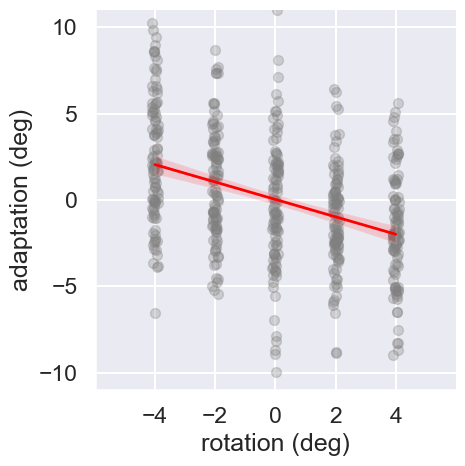

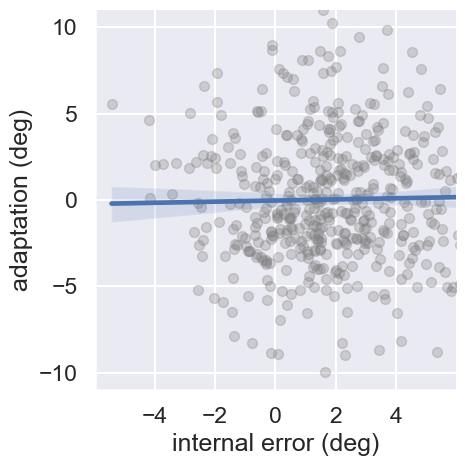

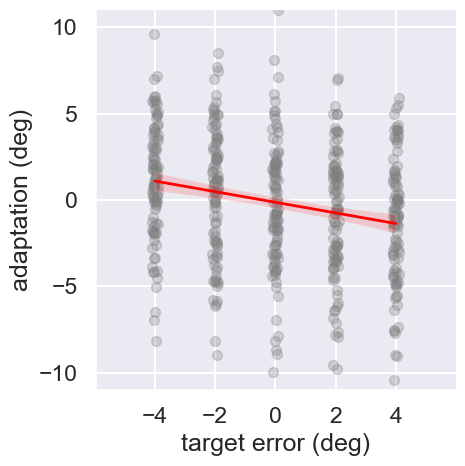

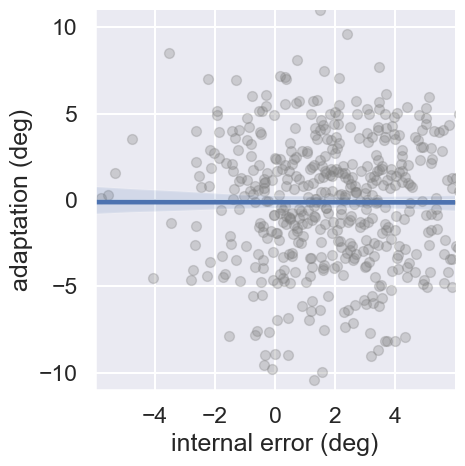

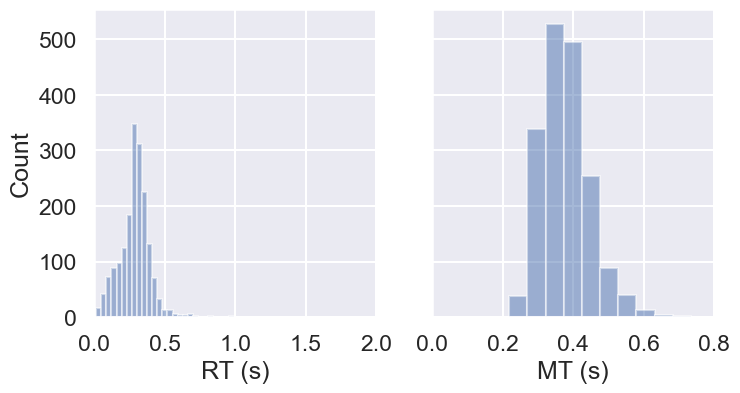

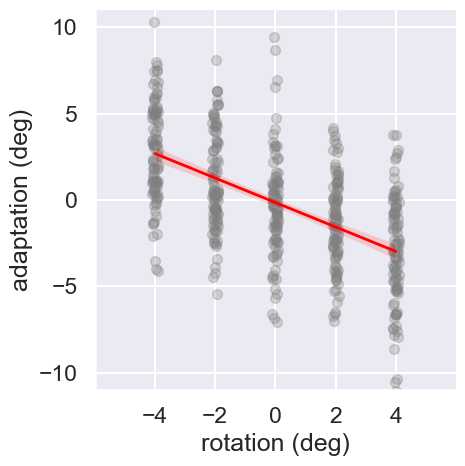

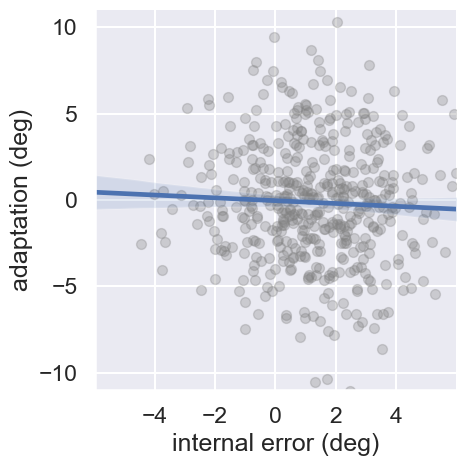

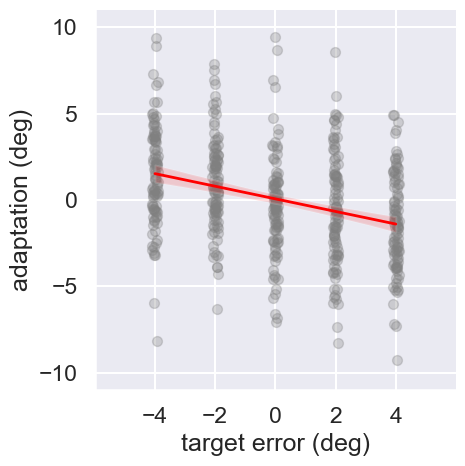

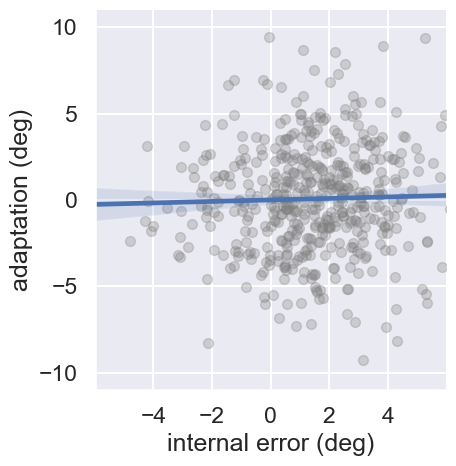

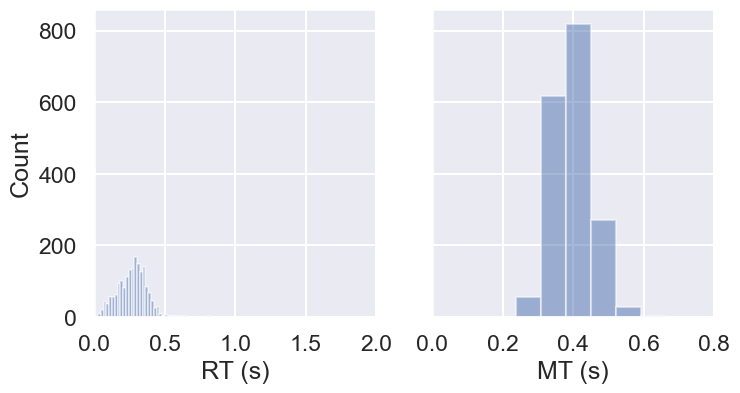

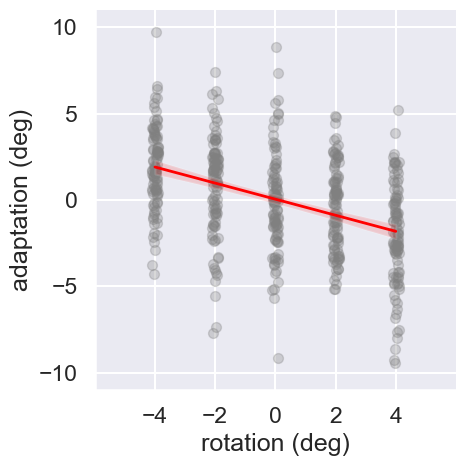

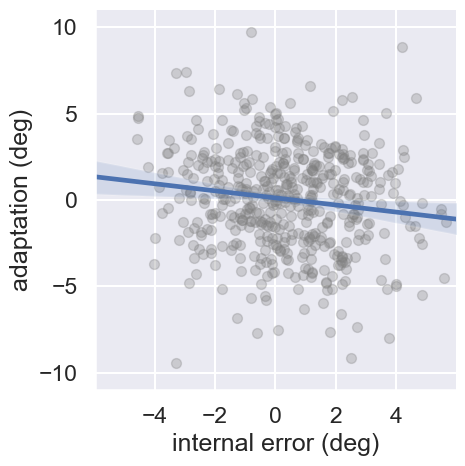

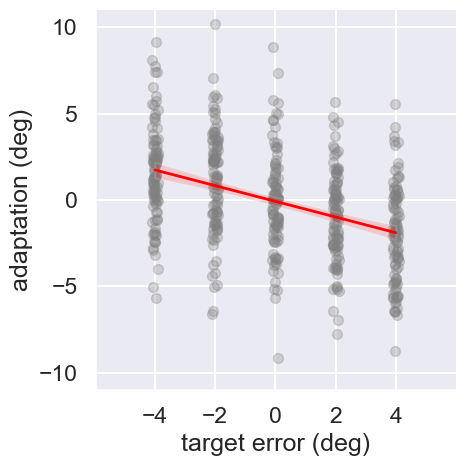

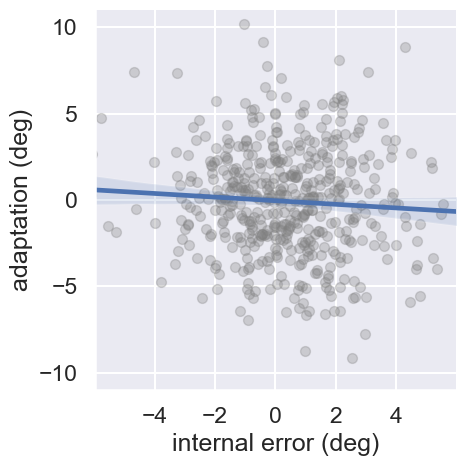

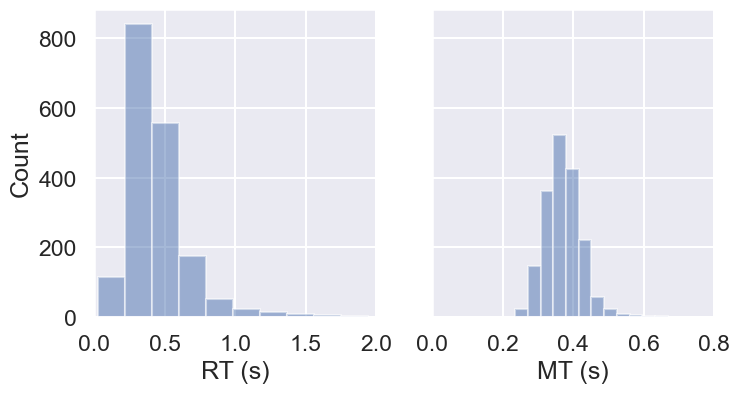

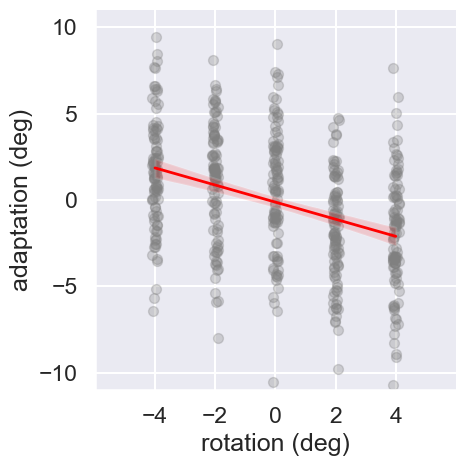

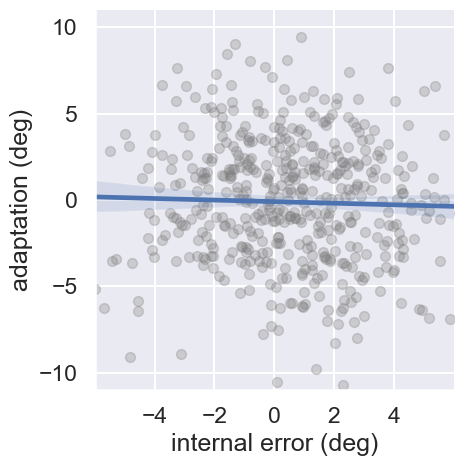

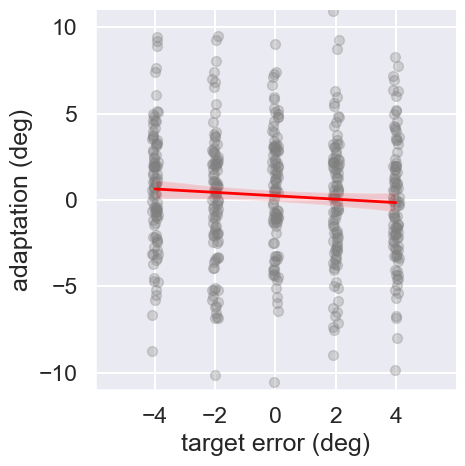

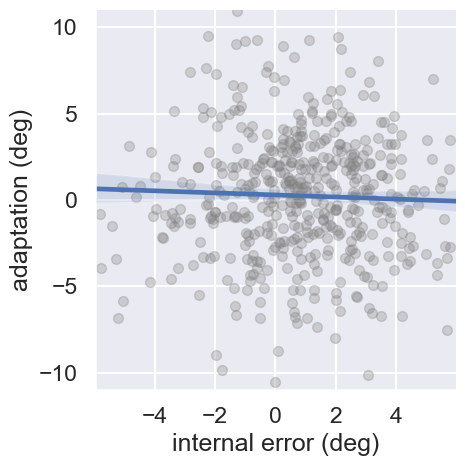

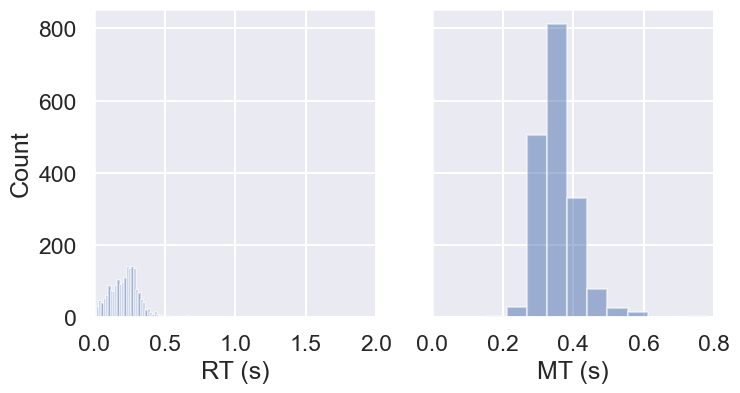

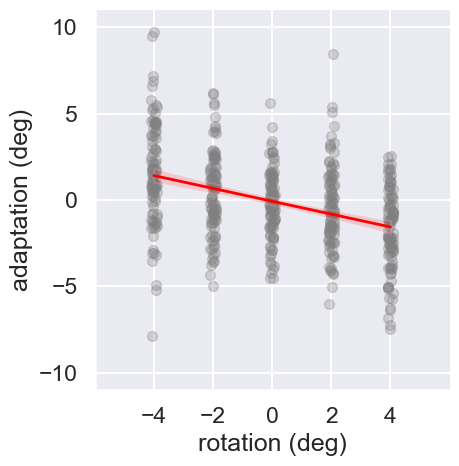

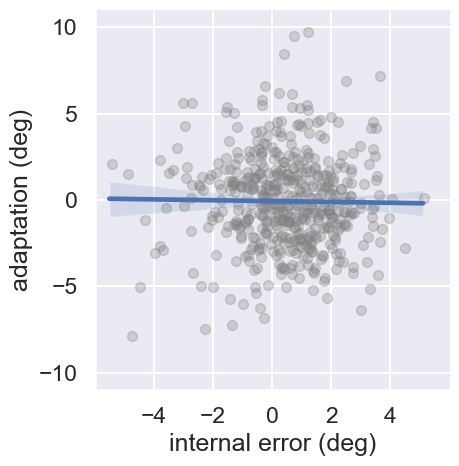

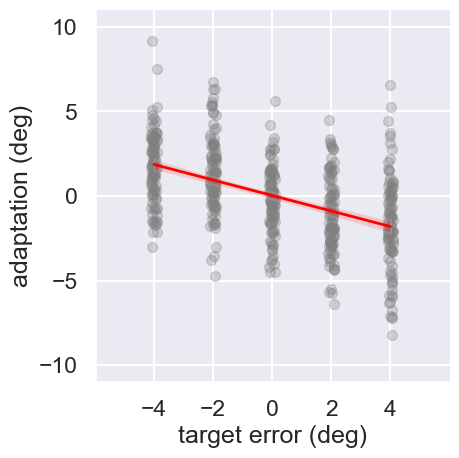

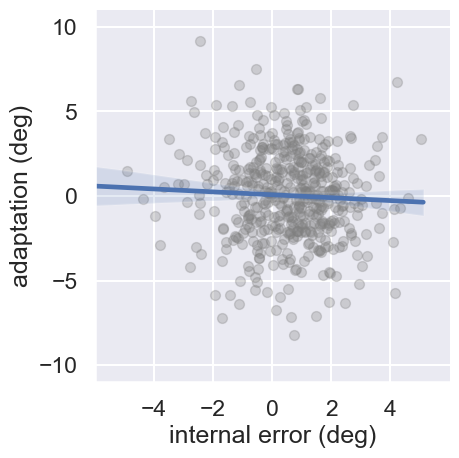

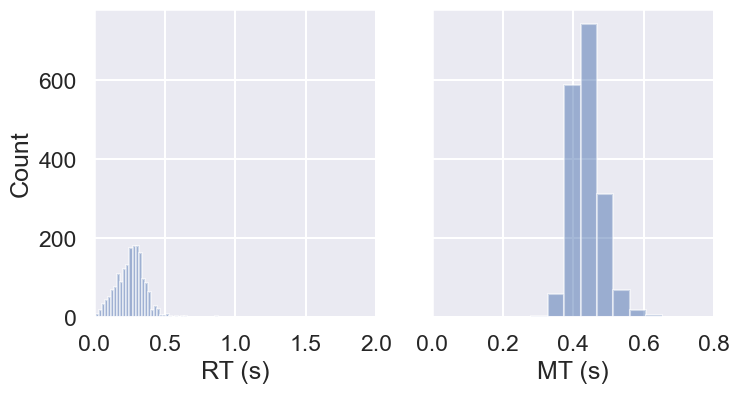

In [9]:
for s in df["id"].unique():

    # Create subject-specific data frame
    subj = df[df["id"] == s].reset_index()
    
    # Create truncated data frame without baseline trials
    training_start = 70
    pert_idx = np.arange(training_start, subj["TN"].max(), 2)
    subj_train = subj.iloc[training_start - 1:, :]
    
    # Loop through trials to get adaptation index
    for i in np.arange(training_start, subj["TN"].max(), 2):
        subj_train.loc[i, "adaptation"] = subj_train.loc[i+1, "theta_maxradv"] - subj_train.loc[i-1, "theta_maxradv"] 
        subj_train.loc[i, "total error"] = subj_train.loc[i, "theta_maxradv"] + subj_train.loc[i, "rotation"]
    
    subj_adapt = subj_train.loc[pert_idx, :].reset_index()
    subj_adapt["tgt_error"] = subj_adapt["tgt_jump"]
    
    # Create separate vmr and target jump data frames
    vmr = subj_adapt.loc[subj_adapt["tgt_jump"] == 0, :]  # Includes 0d rotation
    mask_jump = (subj_adapt["tgt_jump"] != 0) | ((subj_adapt["tgt_jump"] == 0) & (subj_adapt["rotation"] == 0))
    jump = subj_adapt[mask_jump]
    
    # Plot data for adapt vs vmr-ege
    g = sns.lmplot(data=vmr, x="rotation", y="adaptation", x_jitter=0.1, 
               scatter_kws=dict(alpha=0.3, color='gray', s=50), 
               line_kws=dict(linewidth=2, color='red'), ci=95)
    g.set(ylim=(-11, 11), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
      xlabel="rotation (deg)", ylabel="adaptation (deg)")
    # g.savefig("adapt-vmr-ege.png", dpi="figure")
    
    # Plot data for adapt vs ige
    g = sns.lmplot(data=vmr, x="theta_maxradv", y="adaptation", x_jitter=0.1, 
               scatter_kws=dict(alpha=0.3, color='gray', s=50), ci=95)
    g.set(ylim=(-11, 11), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
      xlabel="internal error (deg)", ylabel="adaptation (deg)");
    # g.savefig("adapt-vmr-ige.png")

    # Plot data for adapt vs tgt_jump-ege
    g = sns.lmplot(data=jump, x="tgt_error", y="adaptation", x_jitter=0.1, 
                   scatter_kws=dict(alpha=0.3, color='gray', s=50), 
                   line_kws=dict(linewidth=2, color='red'), ci=95)
    g.set(ylim=(-11, 11), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
          xlabel="target error (deg)", ylabel="adaptation (deg)");
    # g.savefig("adapt-target-jump-ege.png")

    # Plot data for adapt vs ige
    g = sns.lmplot(data=jump, x="theta_maxradv", y="adaptation", x_jitter=0.1, 
                   scatter_kws=dict(alpha=0.3, color='gray', s=50))
    g.set(ylim=(-11, 11), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
          xlabel="internal error (deg)", ylabel="adaptation (deg)");
    # g.savefig("adapt-target-jump-ige.png")

    # Plot RTs and MTs
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
    ax[0].hist(subj_train["RT"], alpha=0.5, bins=40)
    ax[0].set(xlabel="RT (s)", ylabel="Count", xlim=[0, 2])
    ax[1].hist(subj_train["MT"], alpha=0.5, bins=12)
    ax[1].set(xlabel="MT (s)", xlim=[0, 0.8])

    # Print out statistics
    slope, intercept, r_value, p_value, std_err = stats.linregress(vmr["rotation"], vmr["adaptation"])
    print(f"Adaptation to ege-vmr has slope of {slope}, p-val of {p_value}.")

    slope, intercept, r_value, p_value, std_err = stats.linregress(vmr["theta_maxradv"], vmr["adaptation"])
    print(f"Adaptation to ige on rotation trials has slope of {slope}, p-val of {p_value}.")

    slope, intercept, r_value, p_value, std_err = stats.linregress(jump["tgt_error"], jump["adaptation"])
    print(f"Adaptation to ege-target jump has slope of {slope}, p-val of {p_value}.")

    slope, intercept, r_value, p_value, std_err = stats.linregress(jump["theta_maxradv"], jump["adaptation"])
    print(f"Adaptation to ige on target jump has slope of {slope}, p-val of {p_value}.")   

In [10]:
# Median RTs
df.groupby("SN")[["RT", "MT"]].median().reset_index()

,SN,RT,MT
0,1,0.296606,0.371687
1,2,0.283229,0.395789
2,3,0.401357,0.371192
3,4,0.228025,0.348294
4,5,0.273116,0.435530
